<h1 align="center">Deep Learning - HW4 - Q1</h1>
<h3 align="center">Abolfazl Yarian - 400205641 </h3>

REF = https://www.guru99.com/seq2seq-model.html <br>
http://pytorch.org

In [1]:
import datasets
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import re
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# load data and create dataset
lines = open('ferdousi.txt' , encoding='utf-8').read().strip().split('\n')[2:-1]
pairs = []
for c in range(0,len(lines),2):
    pair = [lines[c], lines[c+1]]
    pairs.append(pair)
random.shuffle(pairs)

In [4]:
SOS_token = 0
EOS_token = 1

In [5]:
# class of dictionary 
class Lang:
    def __init__(self, name):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2:"PAD"} #
        self.n_words = 2
        self.name = name

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
# complete instance of dictionary with all dataset
def processing(lang, pairs):
   for pair in pairs:
      lang.addSentence(pair[0])
      lang.addSentence(pair[1])
   print(f"{lang.name} : Counted words = {lang.n_words}")
   return lang

poemLang = Lang("ferdousi")
poemLang = processing(poemLang, pairs)

ferdousi : Counted words = 18013


In [7]:
# converting functions
def indexesFromSentence(lang, sentence):
   return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
   indexes = indexesFromSentence(lang, sentence)
   indexes.append(EOS_token)
   return torch.tensor(indexes, dtype=torch.long,device=device).view(-1, 1)

def tensorsFromPair(input_lang, output_lang, pair):
   input_tensor = tensorFromSentence(input_lang, pair[0])
   target_tensor = tensorFromSentence(output_lang, pair[1])
   return (input_tensor, target_tensor)

In [8]:
training_pairs = [tensorsFromPair(poemLang, poemLang, i) for i in pairs]

In [9]:
def train(Data, Encoder, Decoder, loss_fn, Enc_opt, Dec_opt , epochs, Max_Length ): 
    epochLoss = []
    epochAccuracy = []
    seqLoss = []
    seqAccuracy = []
    size = len(Data)
    for epoch in range(epochs):
        print(f"Epoch = {epoch+1}")
        totalLoss = 0
        totalAccuracy = 0
        random.shuffle(Data)
        for j in tqdm(range(size)):
            input_sen = Data[j][0]
            target_sen = Data[j][1]
            encoder_hidden = Encoder.initHidden()
            Enc_opt.zero_grad()
            Dec_opt.zero_grad()
            encoder_outputs = torch.zeros(Max_Length, Encoder.hidden_size, device=device)
            # Encoder       
            for i in range(input_sen.size(0)):
                encoder_output, encoder_hidden = Encoder(input_sen[i], encoder_hidden)

            decoderHidden = encoder_hidden
            decoder_input = torch.tensor([[SOS_token]], device=device)
            
            loss = 0
            Acc = 0
            # Decoder
            for i in range(target_sen.size(0)):
                decoder_output, decoderHidden = Decoder(decoder_input, decoderHidden)
                loss += loss_fn(decoder_output, target_sen[i])
                Acc += (torch.argmax(decoder_output) ==  target_sen[i][0])
                # Teacher Forcing
                decoder_input = target_sen[i] 
            
            totalLoss += loss.item()/target_sen.size(0)
            totalAccuracy += Acc.item()/target_sen.size(0)
            loss.backward()

            Enc_opt.step()
            Dec_opt.step()
            if j % 1000  == 0 and j!=0:
                avgLoss = totalLoss / 1000
                avgAccuracy = totalAccuracy/1000
                totalLoss = 0
                totalAccuracy = 0
                seqLoss.append(avgLoss)
                seqAccuracy.append(avgAccuracy)  
                print(f"Average Loss = {avgLoss} Average Acc = {avgAccuracy}")      
        epochLoss.append(avgLoss)
        epochAccuracy.append(avgAccuracy)
    return epochLoss, epochAccuracy, seqLoss, seqAccuracy


# Part 1 : Sequence to Sequence with LSTM

In [10]:
# LSTM Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, dropout = 0.5)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device))

In [11]:
# LSTM Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, dropout = 0.5)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = nn.functional.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
def evaluate(Encoder, Decoder, Sentence, Max_Length,poem): 
    input_sen = tensorFromSentence(poem,Sentence)[0].to(device=device)
    encoder_hidden = Encoder.initHidden()
    encoder_outputs = torch.zeros(Max_Length, Encoder.hidden_size, device=device)
    for i in range(input_sen.size(0)):
        encoder_output, encoder_hidden = Encoder(input_sen[i], encoder_hidden)
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    decoded_words = []
    ## Decoder
    for i in range(Max_Length):
        decoder_output, decoder_hidden = Decoder(decoder_input, decoder_hidden)
        y_hat = torch.argmax(decoder_output)
        if y_hat == torch.tensor([[EOS_token]], device=device):
            break
        else:    
            decoded_words.append(poem.index2word[y_hat.item()])  
        # Teacher Forcing
        decoder_input = torch.tensor([y_hat]).to(device=device) 
    return decoded_words

In [13]:
hidden_size = 256
max_length = 15
lr = 0.001
epochs = 5

loss_fn = nn.CrossEntropyLoss()
encoderLstm = Encoder(poemLang.n_words, hidden_size).to(device)
decoderLstm = Decoder(hidden_size, poemLang.n_words).to(device)
encoderOpt = torch.optim.Adam(encoderLstm.parameters(), lr=lr)
decoderOpt = torch.optim.Adam(decoderLstm.parameters(), lr=lr)

/home/user01/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
epochLossLSTM, epochAccLSTM, seqLossLSTM, seqAccLSTM = train (training_pairs,encoderLstm, decoderLstm, loss_fn,\
                                                                     encoderOpt, decoderOpt , epochs, max_length )

Epoch = 1


  2%|▏         | 1015/49608 [00:07<05:55, 136.71it/s]

Average Loss = 6.781124398462007 Average Acc = 0.1858343073593065


  4%|▍         | 2021/49608 [00:15<05:45, 137.64it/s]

Average Loss = 6.356116022000847 Average Acc = 0.18773495670995557


  6%|▌         | 3019/49608 [00:22<05:45, 134.92it/s]

Average Loss = 6.244763838983243 Average Acc = 0.19459145021644902


  8%|▊         | 4019/49608 [00:29<05:44, 132.20it/s]

Average Loss = 6.082979271971304 Average Acc = 0.20116370851370727


 10%|█         | 5021/49608 [00:37<05:34, 133.31it/s]

Average Loss = 6.072640571145059 Average Acc = 0.19722240259740154


 12%|█▏        | 6020/49608 [00:44<05:15, 137.99it/s]

Average Loss = 6.012241128818851 Average Acc = 0.20221717171717035


 14%|█▍        | 7022/49608 [00:52<05:14, 135.51it/s]

Average Loss = 5.933587489664675 Average Acc = 0.20920876623376503


 16%|█▌        | 8016/49608 [00:59<05:02, 137.66it/s]

Average Loss = 5.926936681836131 Average Acc = 0.2087498556998545


 18%|█▊        | 9024/49608 [01:06<05:02, 133.97it/s]

Average Loss = 5.898743957168338 Average Acc = 0.2101503968253957


 20%|██        | 10028/49608 [01:14<04:46, 138.20it/s]

Average Loss = 5.787193558122644 Average Acc = 0.219677453102452


 22%|██▏       | 11015/49608 [01:21<04:45, 135.07it/s]

Average Loss = 5.834820276304202 Average Acc = 0.21463362193362048


 24%|██▍       | 12018/49608 [01:28<04:38, 135.04it/s]

Average Loss = 5.786964664859963 Average Acc = 0.21580887445887295


 26%|██▌       | 13014/49608 [01:36<04:32, 134.32it/s]

Average Loss = 5.76409575263914 Average Acc = 0.22408484848484708


 28%|██▊       | 14016/49608 [01:43<04:20, 136.70it/s]

Average Loss = 5.758172840871783 Average Acc = 0.22579779942279798


 30%|███       | 15017/49608 [01:50<04:16, 134.86it/s]

Average Loss = 5.7430114118322155 Average Acc = 0.23151204906204756


 32%|███▏      | 16017/49608 [01:58<04:08, 135.19it/s]

Average Loss = 5.6953958309409565 Average Acc = 0.2325795454545443


 34%|███▍      | 17017/49608 [02:05<04:05, 132.55it/s]

Average Loss = 5.710097764268545 Average Acc = 0.2342743867243855


 36%|███▋      | 18019/49608 [02:13<03:54, 134.79it/s]

Average Loss = 5.704775987629665 Average Acc = 0.23507936507936383


 38%|███▊      | 19015/49608 [02:20<03:47, 134.53it/s]

Average Loss = 5.668586722661648 Average Acc = 0.23920129870129708


 40%|████      | 20014/49608 [02:27<03:38, 135.58it/s]

Average Loss = 5.702688924500505 Average Acc = 0.24091403318903162


 42%|████▏     | 21016/49608 [02:35<03:26, 138.26it/s]

Average Loss = 5.688818908942896 Average Acc = 0.23838282828282695


 44%|████▍     | 22021/49608 [02:42<03:23, 135.45it/s]

Average Loss = 5.609403762215657 Average Acc = 0.24631944444444287


 46%|████▋     | 23020/49608 [02:50<03:18, 133.75it/s]

Average Loss = 5.6503321033364955 Average Acc = 0.24681572871572743


 48%|████▊     | 24016/49608 [02:57<03:13, 131.98it/s]

Average Loss = 5.547290747638046 Average Acc = 0.24826226551226407


 50%|█████     | 25021/49608 [03:05<02:58, 137.83it/s]

Average Loss = 5.5627089764331545 Average Acc = 0.24953993506493366


 52%|█████▏    | 26022/49608 [03:12<02:51, 137.14it/s]

Average Loss = 5.590254075287194 Average Acc = 0.24996096681096552


 54%|█████▍    | 27028/49608 [03:19<02:48, 134.38it/s]

Average Loss = 5.6934703292286635 Average Acc = 0.250285714285713


 56%|█████▋    | 28016/49608 [03:27<02:43, 132.12it/s]

Average Loss = 5.521495203717138 Average Acc = 0.25594411976911857


 58%|█████▊    | 29017/49608 [03:34<02:33, 133.80it/s]

Average Loss = 5.596601301297693 Average Acc = 0.2634488095238086


 61%|██████    | 30015/49608 [03:42<02:27, 132.52it/s]

Average Loss = 5.524001835604187 Average Acc = 0.2650908008657997


 63%|██████▎   | 31018/49608 [03:49<02:14, 137.73it/s]

Average Loss = 5.622601417101335 Average Acc = 0.25859758297258195


 65%|██████▍   | 32016/49608 [03:56<02:08, 136.51it/s]

Average Loss = 5.615925224267873 Average Acc = 0.2563315656565646


 67%|██████▋   | 33020/49608 [04:04<02:01, 136.15it/s]

Average Loss = 5.678139392971609 Average Acc = 0.2583396825396813


 69%|██████▊   | 34017/49608 [04:11<01:58, 131.46it/s]

Average Loss = 5.540477989248249 Average Acc = 0.2612869047619036


 71%|███████   | 35015/49608 [04:18<01:48, 134.57it/s]

Average Loss = 5.554471485273351 Average Acc = 0.2630786435786423


 73%|███████▎  | 36020/49608 [04:26<01:40, 135.25it/s]

Average Loss = 5.454223479669333 Average Acc = 0.27295093795093667


 75%|███████▍  | 37026/49608 [04:33<01:33, 134.55it/s]

Average Loss = 5.465697961607086 Average Acc = 0.26900981240981175


 77%|███████▋  | 38019/49608 [04:41<01:24, 137.67it/s]

Average Loss = 5.620651898499896 Average Acc = 0.2668769841269831


 79%|███████▊  | 39019/49608 [04:48<01:17, 136.93it/s]

Average Loss = 5.501826216312577 Average Acc = 0.27065919913419784


 81%|████████  | 40028/49608 [04:55<01:09, 137.48it/s]

Average Loss = 5.563701750680652 Average Acc = 0.26883953823953677


 83%|████████▎ | 41028/49608 [05:03<01:02, 137.56it/s]

Average Loss = 5.608173175816724 Average Acc = 0.26507326839826717


 85%|████████▍ | 42024/49608 [05:10<00:55, 137.50it/s]

Average Loss = 5.571896554745846 Average Acc = 0.2727131673881667


 87%|████████▋ | 43020/49608 [05:17<00:48, 137.21it/s]

Average Loss = 5.539288779835472 Average Acc = 0.2775809523809514


 89%|████████▊ | 44025/49608 [05:25<00:41, 133.67it/s]

Average Loss = 5.421337316520772 Average Acc = 0.27723430735930654


 91%|█████████ | 45028/49608 [05:32<00:33, 138.11it/s]

Average Loss = 5.622647503285177 Average Acc = 0.2750309523809513


 93%|█████████▎| 46015/49608 [05:40<00:26, 133.93it/s]

Average Loss = 5.522096978150053 Average Acc = 0.27480335497835423


 95%|█████████▍| 47024/49608 [05:47<00:18, 136.26it/s]

Average Loss = 5.511163073586802 Average Acc = 0.2719852453102442


 97%|█████████▋| 48023/49608 [05:54<00:11, 135.04it/s]

Average Loss = 5.528836788186851 Average Acc = 0.28010119047618975


 99%|█████████▉| 49027/49608 [06:02<00:04, 131.25it/s]

Average Loss = 5.437423269541298 Average Acc = 0.27799960317460226


100%|██████████| 49608/49608 [06:06<00:00, 135.35it/s]


Epoch = 2


  2%|▏         | 1016/49608 [00:07<05:45, 140.63it/s]

Average Loss = 5.065455092689792 Average Acc = 0.29850526695526636


  4%|▍         | 2015/49608 [00:14<05:48, 136.38it/s]

Average Loss = 5.052949345820431 Average Acc = 0.2994230519480512


  6%|▌         | 3019/49608 [00:22<05:45, 134.91it/s]

Average Loss = 5.0860480234977885 Average Acc = 0.29143903318903225


  8%|▊         | 4027/49608 [00:29<05:26, 139.62it/s]

Average Loss = 5.072143388971657 Average Acc = 0.30270685425685395


 10%|█         | 5020/49608 [00:36<05:30, 134.80it/s]

Average Loss = 5.011532628994142 Average Acc = 0.2935889249639242


 12%|█▏        | 6019/49608 [00:44<05:22, 135.07it/s]

Average Loss = 5.115642628773015 Average Acc = 0.29966886724386615


 14%|█▍        | 7022/49608 [00:51<05:17, 134.14it/s]

Average Loss = 5.151942763924908 Average Acc = 0.2958572871572864


 16%|█▌        | 8023/49608 [00:59<05:10, 134.10it/s]

Average Loss = 5.103852107014731 Average Acc = 0.29626230158730127


 18%|█▊        | 9023/49608 [01:06<04:59, 135.33it/s]

Average Loss = 5.136055249320269 Average Acc = 0.2982392857142849


 20%|██        | 10027/49608 [01:13<04:51, 135.99it/s]

Average Loss = 5.21528204181156 Average Acc = 0.29947738095238013


 22%|██▏       | 11019/49608 [01:21<04:40, 137.41it/s]

Average Loss = 5.155358220429645 Average Acc = 0.29476031746031633


 24%|██▍       | 12017/49608 [01:28<04:40, 133.94it/s]

Average Loss = 5.084777241917738 Average Acc = 0.3038224386724379


 26%|██▌       | 13018/49608 [01:35<04:30, 135.11it/s]

Average Loss = 5.078140136293517 Average Acc = 0.2995486291486284


 28%|██▊       | 14017/49608 [01:43<04:20, 136.43it/s]

Average Loss = 5.07270029875018 Average Acc = 0.2994734848484837


 30%|███       | 15017/49608 [01:50<04:13, 136.48it/s]

Average Loss = 5.163906912446854 Average Acc = 0.301584343434343


 32%|███▏      | 16024/49608 [01:58<04:04, 137.30it/s]

Average Loss = 5.149726392642338 Average Acc = 0.3001264069264055


 34%|███▍      | 17018/49608 [02:05<03:57, 137.39it/s]

Average Loss = 5.254752541619601 Average Acc = 0.29908163780663677


 36%|███▋      | 18018/49608 [02:12<03:55, 134.37it/s]

Average Loss = 5.134671636448554 Average Acc = 0.3031436507936502


 38%|███▊      | 19018/49608 [02:20<03:45, 135.79it/s]

Average Loss = 5.184050719316424 Average Acc = 0.29972142857142786


 40%|████      | 20018/49608 [02:27<03:38, 135.43it/s]

Average Loss = 5.252656908127031 Average Acc = 0.2968247113997113


 42%|████▏     | 21019/49608 [02:35<03:32, 134.40it/s]

Average Loss = 5.177492098600133 Average Acc = 0.2957821428571417


 44%|████▍     | 22029/49608 [02:42<03:17, 139.85it/s]

Average Loss = 5.226194337617921 Average Acc = 0.2991120851370846


 46%|████▋     | 23016/49608 [02:49<03:10, 139.34it/s]

Average Loss = 5.204047496614551 Average Acc = 0.3003590187590177


 48%|████▊     | 24017/49608 [02:57<03:10, 134.00it/s]

Average Loss = 5.187056227875442 Average Acc = 0.3015745670995664


 50%|█████     | 25026/49608 [03:04<02:58, 138.09it/s]

Average Loss = 5.133184099367687 Average Acc = 0.29816746031745955


 52%|█████▏    | 26018/49608 [03:11<02:56, 133.71it/s]

Average Loss = 5.1888356841546965 Average Acc = 0.30412377344877284


 54%|█████▍    | 27017/49608 [03:19<02:46, 135.95it/s]

Average Loss = 5.180554131025944 Average Acc = 0.3078454184704174


 56%|█████▋    | 28015/49608 [03:26<02:42, 132.68it/s]

Average Loss = 5.249323097272318 Average Acc = 0.3017209235209222


 58%|█████▊    | 29016/49608 [03:34<02:28, 138.23it/s]

Average Loss = 5.284208533278345 Average Acc = 0.2973682539682534


 61%|██████    | 30020/49608 [03:41<02:28, 131.81it/s]

Average Loss = 5.169894052648815 Average Acc = 0.3102648989898983


 63%|██████▎   | 31021/49608 [03:49<02:21, 131.61it/s]

Average Loss = 5.220546692542872 Average Acc = 0.30679184704184626


 65%|██████▍   | 32018/49608 [03:56<02:10, 134.43it/s]

Average Loss = 5.20458846716647 Average Acc = 0.30271587301587266


 67%|██████▋   | 33021/49608 [04:03<01:59, 138.41it/s]

Average Loss = 5.215936618774658 Average Acc = 0.2997005772005763


 69%|██████▊   | 34023/49608 [04:11<01:52, 138.86it/s]

Average Loss = 5.124405103879365 Average Acc = 0.30148520923520855


 71%|███████   | 35023/49608 [04:18<01:45, 138.07it/s]

Average Loss = 5.137538208114538 Average Acc = 0.30208553391053306


 73%|███████▎  | 36021/49608 [04:25<01:41, 133.30it/s]

Average Loss = 5.297043395226504 Average Acc = 0.30594455266955245


 75%|███████▍  | 37020/49608 [04:33<01:36, 130.82it/s]

Average Loss = 5.2281260477861515 Average Acc = 0.2962978715728711


 77%|███████▋  | 38020/49608 [04:40<01:26, 134.20it/s]

Average Loss = 5.107573972446851 Average Acc = 0.30044134199134115


 79%|███████▊  | 39026/49608 [04:48<01:16, 137.72it/s]

Average Loss = 5.2452086461298055 Average Acc = 0.2996010101010097


 81%|████████  | 40016/49608 [04:55<01:10, 136.34it/s]

Average Loss = 5.1014041158145655 Average Acc = 0.3047842352092342


 83%|████████▎ | 41018/49608 [05:02<01:04, 133.72it/s]

Average Loss = 5.287622840807973 Average Acc = 0.30606998556998477


 85%|████████▍ | 42027/49608 [05:10<00:54, 138.16it/s]

Average Loss = 5.165385762010512 Average Acc = 0.31133506493506413


 87%|████████▋ | 43014/49608 [05:17<00:48, 136.81it/s]

Average Loss = 5.309405753451516 Average Acc = 0.30270266955266867


 89%|████████▉ | 44028/49608 [05:25<00:41, 134.35it/s]

Average Loss = 5.1528933452311 Average Acc = 0.311431818181818


 91%|█████████ | 45023/49608 [05:32<00:33, 135.89it/s]

Average Loss = 5.198022758299959 Average Acc = 0.3058773809523801


 93%|█████████▎| 46020/49608 [05:39<00:26, 135.52it/s]

Average Loss = 5.272271687207977 Average Acc = 0.3069909090909082


 95%|█████████▍| 47023/49608 [05:47<00:19, 133.94it/s]

Average Loss = 5.268372909382788 Average Acc = 0.3049095238095234


 97%|█████████▋| 48020/49608 [05:54<00:12, 131.53it/s]

Average Loss = 5.18703521873923 Average Acc = 0.3059223304473299


 99%|█████████▉| 49020/49608 [06:02<00:04, 135.67it/s]

Average Loss = 5.210568611110958 Average Acc = 0.3030757936507929


100%|██████████| 49608/49608 [06:06<00:00, 135.35it/s]


Epoch = 3


  2%|▏         | 1015/49608 [00:07<05:54, 137.07it/s]

Average Loss = 4.783035965834307 Average Acc = 0.3198674963924956


  4%|▍         | 2018/49608 [00:14<05:48, 136.70it/s]

Average Loss = 4.731196773024968 Average Acc = 0.32831746031746023


  6%|▌         | 3015/49608 [00:22<05:39, 137.15it/s]

Average Loss = 4.806831623422837 Average Acc = 0.3217616161616156


  8%|▊         | 4019/49608 [00:29<05:37, 134.91it/s]

Average Loss = 4.774411024442063 Average Acc = 0.32716948051947964


 10%|█         | 5021/49608 [00:37<05:28, 135.73it/s]

Average Loss = 4.779209510785228 Average Acc = 0.3253389610389602


 12%|█▏        | 6022/49608 [00:44<05:25, 134.05it/s]

Average Loss = 4.842663595344564 Average Acc = 0.3207744949494946


 14%|█▍        | 7025/49608 [00:51<05:12, 136.10it/s]

Average Loss = 4.83427446158129 Average Acc = 0.3272535353535346


 16%|█▌        | 8017/49608 [00:59<05:09, 134.41it/s]

Average Loss = 4.76732985287748 Average Acc = 0.3295359307359299


 18%|█▊        | 9028/49608 [01:06<04:56, 136.81it/s]

Average Loss = 4.812427578707349 Average Acc = 0.31786565656565613


 20%|██        | 10015/49608 [01:13<04:48, 137.33it/s]

Average Loss = 4.9285705663942165 Average Acc = 0.3140316017316012


 22%|██▏       | 11019/49608 [01:21<04:46, 134.52it/s]

Average Loss = 4.916134334240465 Average Acc = 0.3197405844155834


 24%|██▍       | 12016/49608 [01:28<04:39, 134.40it/s]

Average Loss = 4.777962553833776 Average Acc = 0.33165984848484775


 26%|██▌       | 13016/49608 [01:36<04:29, 135.76it/s]

Average Loss = 4.790585403346264 Average Acc = 0.3271075396825389


 28%|██▊       | 14022/49608 [01:43<04:19, 137.04it/s]

Average Loss = 4.936789405961262 Average Acc = 0.31813611111111045


 30%|███       | 15023/49608 [01:50<04:06, 140.29it/s]

Average Loss = 4.848773145308398 Average Acc = 0.3250234848484841


 32%|███▏      | 16020/49608 [01:58<04:03, 138.18it/s]

Average Loss = 4.823395859427578 Average Acc = 0.32740082972582907


 34%|███▍      | 17025/49608 [02:05<03:58, 136.61it/s]

Average Loss = 4.953237938745396 Average Acc = 0.31841782106782035


 36%|███▋      | 18015/49608 [02:12<03:57, 133.19it/s]

Average Loss = 4.868426245554149 Average Acc = 0.32973437950937906


 38%|███▊      | 19024/49608 [02:20<03:41, 137.90it/s]

Average Loss = 4.884943235427368 Average Acc = 0.325641197691197


 40%|████      | 20023/49608 [02:27<03:37, 135.84it/s]

Average Loss = 4.937870809152766 Average Acc = 0.31736031746031634


 42%|████▏     | 21025/49608 [02:34<03:30, 135.63it/s]

Average Loss = 4.935477109115085 Average Acc = 0.3286146825396819


 44%|████▍     | 22022/49608 [02:42<03:30, 131.23it/s]

Average Loss = 4.936061317631247 Average Acc = 0.3259204545454539


 46%|████▋     | 23016/49608 [02:49<03:21, 132.19it/s]

Average Loss = 4.791020222308896 Average Acc = 0.3326256854256845


 48%|████▊     | 24026/49608 [02:57<03:09, 134.88it/s]

Average Loss = 4.895815386401203 Average Acc = 0.32519935064935007


 50%|█████     | 25024/49608 [03:04<02:57, 138.46it/s]

Average Loss = 4.9017117906990535 Average Acc = 0.3291142857142851


 52%|█████▏    | 26016/49608 [03:11<02:53, 135.65it/s]

Average Loss = 4.937664661957349 Average Acc = 0.3269186507936503


 54%|█████▍    | 27019/49608 [03:19<02:44, 136.92it/s]

Average Loss = 4.907996794332953 Average Acc = 0.32810786435786315


 56%|█████▋    | 28019/49608 [03:26<02:40, 134.44it/s]

Average Loss = 4.938218932933282 Average Acc = 0.3256428571428567


 58%|█████▊    | 29019/49608 [03:34<02:33, 134.48it/s]

Average Loss = 4.9269284143282395 Average Acc = 0.32899855699855607


 61%|██████    | 30015/49608 [03:41<02:24, 135.68it/s]

Average Loss = 4.89451931495553 Average Acc = 0.32623253968253885


 63%|██████▎   | 31016/49608 [03:49<02:12, 140.16it/s]

Average Loss = 4.973241986976113 Average Acc = 0.3226019480519473


 65%|██████▍   | 32018/49608 [03:56<02:07, 137.64it/s]

Average Loss = 4.872434271112631 Average Acc = 0.32073463203463115


 67%|██████▋   | 33027/49608 [04:03<02:01, 136.26it/s]

Average Loss = 5.025597133669779 Average Acc = 0.32325577200577044


 69%|██████▊   | 34015/49608 [04:11<01:54, 136.42it/s]

Average Loss = 4.931918605154899 Average Acc = 0.32079094516594403


 71%|███████   | 35027/49608 [04:18<01:47, 135.92it/s]

Average Loss = 4.906735778391864 Average Acc = 0.32976443001442907


 73%|███████▎  | 36019/49608 [04:25<01:41, 133.53it/s]

Average Loss = 4.8990897722273505 Average Acc = 0.32397489177489075


 75%|███████▍  | 37021/49608 [04:33<01:33, 135.30it/s]

Average Loss = 4.903878686526679 Average Acc = 0.3181940836940829


 77%|███████▋  | 38026/49608 [04:40<01:24, 137.82it/s]

Average Loss = 4.9972213971956725 Average Acc = 0.3156319264069258


 79%|███████▊  | 39024/49608 [04:47<01:17, 136.69it/s]

Average Loss = 5.0184418585994734 Average Acc = 0.32213722943722883


 81%|████████  | 40021/49608 [04:55<01:10, 135.95it/s]

Average Loss = 4.901914145104468 Average Acc = 0.32840873015872923


 83%|████████▎ | 41021/49608 [05:02<01:04, 133.57it/s]

Average Loss = 5.1270425005042455 Average Acc = 0.31662896825396736


 85%|████████▍ | 42018/49608 [05:10<00:57, 131.87it/s]

Average Loss = 4.995101556150249 Average Acc = 0.31639455266955185


 87%|████████▋ | 43016/49608 [05:17<00:48, 134.89it/s]

Average Loss = 4.991427824857878 Average Acc = 0.31858531746031665


 89%|████████▊ | 44018/49608 [05:24<00:41, 133.98it/s]

Average Loss = 5.042113078785662 Average Acc = 0.3144747835497828


 91%|█████████ | 45024/49608 [05:32<00:33, 137.10it/s]

Average Loss = 5.010032124406431 Average Acc = 0.3211937229437222


 93%|█████████▎| 46022/49608 [05:39<00:26, 133.74it/s]

Average Loss = 5.064584500184691 Average Acc = 0.3204325036075032


 95%|█████████▍| 47020/49608 [05:47<00:18, 136.28it/s]

Average Loss = 4.9670880304449705 Average Acc = 0.3195789682539675


 97%|█████████▋| 48018/49608 [05:54<00:11, 135.58it/s]

Average Loss = 5.128451768207825 Average Acc = 0.3147363997113993


 99%|█████████▉| 49021/49608 [06:01<00:04, 136.79it/s]

Average Loss = 5.061392561140573 Average Acc = 0.3179883116883108


100%|██████████| 49608/49608 [06:06<00:00, 135.46it/s]


Epoch = 4


  2%|▏         | 1025/49608 [00:07<05:56, 136.14it/s]

Average Loss = 4.521358454450589 Average Acc = 0.3523764069264065


  4%|▍         | 2021/49608 [00:14<05:56, 133.44it/s]

Average Loss = 4.525361215086968 Average Acc = 0.3400734126984124


  6%|▌         | 3026/49608 [00:22<05:41, 136.59it/s]

Average Loss = 4.412500343618595 Average Acc = 0.34539361471861396


  8%|▊         | 4016/49608 [00:29<05:29, 138.22it/s]

Average Loss = 4.444882533209009 Average Acc = 0.34858322510822454


 10%|█         | 5018/49608 [00:37<05:31, 134.35it/s]

Average Loss = 4.483196822756883 Average Acc = 0.3454861832611825


 12%|█▏        | 6021/49608 [00:44<05:28, 132.67it/s]

Average Loss = 4.535103664252705 Average Acc = 0.35012792207792154


 14%|█▍        | 7018/49608 [00:51<05:14, 135.41it/s]

Average Loss = 4.576930976124684 Average Acc = 0.34201345598845545


 16%|█▌        | 8020/49608 [00:59<05:13, 132.53it/s]

Average Loss = 4.493416112014635 Average Acc = 0.3452791847041841


 18%|█▊        | 9026/49608 [01:06<05:00, 134.91it/s]

Average Loss = 4.604692773221084 Average Acc = 0.3410519119769116


 20%|██        | 10028/49608 [01:14<04:43, 139.64it/s]

Average Loss = 4.5506773277113375 Average Acc = 0.34743668831168784


 22%|██▏       | 11026/49608 [01:21<04:47, 134.27it/s]

Average Loss = 4.66465795228925 Average Acc = 0.3418529581529573


 24%|██▍       | 12025/49608 [01:28<04:31, 138.34it/s]

Average Loss = 4.66993176985066 Average Acc = 0.3373124458874447


 26%|██▌       | 13021/49608 [01:35<04:31, 134.67it/s]

Average Loss = 4.7073637617241575 Average Acc = 0.33168481240981146


 28%|██▊       | 14017/49608 [01:43<04:20, 136.47it/s]

Average Loss = 4.590991024695385 Average Acc = 0.34022258297258223


 30%|███       | 15015/49608 [01:50<04:12, 137.01it/s]

Average Loss = 4.7100413705148725 Average Acc = 0.33567211399711316


 32%|███▏      | 16020/49608 [01:57<04:11, 133.54it/s]

Average Loss = 4.733064159850807 Average Acc = 0.3350413780663772


 34%|███▍      | 17017/49608 [02:05<03:59, 136.09it/s]

Average Loss = 4.670284394381538 Average Acc = 0.3383585858585846


 36%|███▋      | 18024/49608 [02:12<03:51, 136.55it/s]

Average Loss = 4.726436276016225 Average Acc = 0.33703795093795025


 38%|███▊      | 19026/49608 [02:20<03:45, 135.68it/s]

Average Loss = 4.823362941713969 Average Acc = 0.33375425685425647


 40%|████      | 20029/49608 [02:27<03:31, 140.01it/s]

Average Loss = 4.587432867669987 Average Acc = 0.3418034271284261


 42%|████▏     | 21019/49608 [02:34<03:30, 135.84it/s]

Average Loss = 4.606536990160788 Average Acc = 0.33656865079365017


 44%|████▍     | 22019/49608 [02:42<03:27, 132.70it/s]

Average Loss = 4.699792349417664 Average Acc = 0.3389625541125536


 46%|████▋     | 23018/49608 [02:49<03:15, 135.97it/s]

Average Loss = 4.847334313537586 Average Acc = 0.32986111111111077


 48%|████▊     | 24019/49608 [02:56<03:08, 135.99it/s]

Average Loss = 4.786200147805998 Average Acc = 0.331407792207791


 50%|█████     | 25019/49608 [03:04<03:01, 135.51it/s]

Average Loss = 4.814525290280988 Average Acc = 0.334901984126983


 52%|█████▏    | 26021/49608 [03:11<02:53, 136.15it/s]

Average Loss = 4.807091385413633 Average Acc = 0.33175162337662306


 54%|█████▍    | 27028/49608 [03:19<02:42, 138.89it/s]

Average Loss = 4.807840846716234 Average Acc = 0.33907929292929223


 56%|█████▋    | 28020/49608 [03:26<02:39, 135.30it/s]

Average Loss = 4.779957001902288 Average Acc = 0.33113621933621873


 58%|█████▊    | 29020/49608 [03:33<02:34, 132.94it/s]

Average Loss = 4.808097390202489 Average Acc = 0.32973055555555547


 61%|██████    | 30028/49608 [03:41<02:23, 136.46it/s]

Average Loss = 4.754265079584993 Average Acc = 0.338784415584415


 63%|██████▎   | 31022/49608 [03:48<02:19, 133.38it/s]

Average Loss = 4.6134929469279875 Average Acc = 0.34459433621933655


 65%|██████▍   | 32023/49608 [03:56<02:09, 135.70it/s]

Average Loss = 4.78243823969461 Average Acc = 0.3321149350649346


 67%|██████▋   | 33023/49608 [04:03<02:02, 135.61it/s]

Average Loss = 4.857964022275689 Average Acc = 0.3398784271284266


 69%|██████▊   | 34019/49608 [04:10<01:56, 134.23it/s]

Average Loss = 4.889234337409195 Average Acc = 0.3242298340548329


 71%|███████   | 35017/49608 [04:18<01:48, 134.16it/s]

Average Loss = 4.763304800871954 Average Acc = 0.33105010822510783


 73%|███████▎  | 36021/49608 [04:25<01:40, 135.61it/s]

Average Loss = 4.799984605006187 Average Acc = 0.3365781746031737


 75%|███████▍  | 37027/49608 [04:33<01:32, 136.40it/s]

Average Loss = 4.883118330611772 Average Acc = 0.3276417388167384


 77%|███████▋  | 38018/49608 [04:40<01:24, 136.44it/s]

Average Loss = 4.855409803614915 Average Acc = 0.33031309523809455


 79%|███████▊  | 39023/49608 [04:47<01:15, 139.60it/s]

Average Loss = 4.733708654603923 Average Acc = 0.3347335137085132


 81%|████████  | 40020/49608 [04:55<01:09, 138.10it/s]

Average Loss = 4.753033906461839 Average Acc = 0.3369192640692629


 83%|████████▎ | 41021/49608 [05:02<01:03, 134.75it/s]

Average Loss = 4.838382559052725 Average Acc = 0.3324842712842707


 85%|████████▍ | 42019/49608 [05:09<00:56, 134.71it/s]

Average Loss = 4.889493413840772 Average Acc = 0.3269793290043278


 87%|████████▋ | 43022/49608 [05:17<00:47, 137.36it/s]

Average Loss = 4.850357239638023 Average Acc = 0.3390384559884552


 89%|████████▊ | 44027/49608 [05:24<00:40, 137.46it/s]

Average Loss = 4.958384487137722 Average Acc = 0.3296785714285709


 91%|█████████ | 45015/49608 [05:31<00:34, 133.68it/s]

Average Loss = 4.85251941200548 Average Acc = 0.3243329725829723


 93%|█████████▎| 46016/49608 [05:39<00:26, 136.25it/s]

Average Loss = 4.805194071568182 Average Acc = 0.3316978715728711


 95%|█████████▍| 47024/49608 [05:46<00:18, 138.41it/s]

Average Loss = 4.939443005579408 Average Acc = 0.32982124819624786


 97%|█████████▋| 48018/49608 [05:54<00:11, 136.42it/s]

Average Loss = 4.788143049021753 Average Acc = 0.33406706349206267


 99%|█████████▉| 49028/49608 [06:01<00:04, 137.39it/s]

Average Loss = 4.8252694637521865 Average Acc = 0.3347081529581524


100%|██████████| 49608/49608 [06:05<00:00, 135.60it/s]


Epoch = 5


  2%|▏         | 1015/49608 [00:07<05:56, 136.23it/s]

Average Loss = 4.200255915732714 Average Acc = 0.3627207792207784


  4%|▍         | 2016/49608 [00:14<05:51, 135.34it/s]

Average Loss = 4.349092558582236 Average Acc = 0.359148015873015


  6%|▌         | 3025/49608 [00:22<05:41, 136.43it/s]

Average Loss = 4.3305724049569285 Average Acc = 0.34828556998556937


  8%|▊         | 4018/49608 [00:29<05:31, 137.70it/s]

Average Loss = 4.272190529922078 Average Acc = 0.35851190476190403


 10%|█         | 5021/49608 [00:36<05:27, 135.99it/s]

Average Loss = 4.351605394196059 Average Acc = 0.35688037518037447


 12%|█▏        | 6027/49608 [00:44<05:20, 135.78it/s]

Average Loss = 4.263605784258219 Average Acc = 0.36109945887445827


 14%|█▍        | 7017/49608 [00:51<05:10, 137.33it/s]

Average Loss = 4.334035636955076 Average Acc = 0.3608922077922067


 16%|█▌        | 8022/49608 [00:58<05:09, 134.52it/s]

Average Loss = 4.3569631189876095 Average Acc = 0.35472579365079365


 18%|█▊        | 9021/49608 [01:06<04:57, 136.28it/s]

Average Loss = 4.500657862531675 Average Acc = 0.3473514069264064


 20%|██        | 10023/49608 [01:13<04:52, 135.13it/s]

Average Loss = 4.390529538419103 Average Acc = 0.3541713203463194


 22%|██▏       | 11021/49608 [01:21<04:54, 131.03it/s]

Average Loss = 4.438504268182891 Average Acc = 0.3459572871572862


 24%|██▍       | 12026/49608 [01:28<04:37, 135.41it/s]

Average Loss = 4.446044774359322 Average Acc = 0.3522706709956703


 26%|██▋       | 13025/49608 [01:36<04:33, 133.64it/s]

Average Loss = 4.3654654232051255 Average Acc = 0.35768459595959534


 28%|██▊       | 14025/49608 [01:43<04:22, 135.61it/s]

Average Loss = 4.471639689427989 Average Acc = 0.35623138528138465


 30%|███       | 15014/49608 [01:50<04:19, 133.53it/s]

Average Loss = 4.474829176490357 Average Acc = 0.34657348484848427


 32%|███▏      | 16025/49608 [01:58<04:06, 136.28it/s]

Average Loss = 4.551423698116698 Average Acc = 0.3498764430014426


 34%|███▍      | 17021/49608 [02:05<03:57, 137.24it/s]

Average Loss = 4.537876327109335 Average Acc = 0.341593253968253


 36%|███▋      | 18024/49608 [02:12<03:49, 137.47it/s]

Average Loss = 4.4677017003261295 Average Acc = 0.3472931096681094


 38%|███▊      | 19028/49608 [02:20<03:44, 136.16it/s]

Average Loss = 4.537002512150722 Average Acc = 0.3457876984126978


 40%|████      | 20016/49608 [02:27<03:40, 134.35it/s]

Average Loss = 4.531886889240405 Average Acc = 0.3449928210678208


 42%|████▏     | 21026/49608 [02:34<03:37, 131.63it/s]

Average Loss = 4.447981740946997 Average Acc = 0.3481726190476184


 44%|████▍     | 22024/49608 [02:42<03:27, 133.11it/s]

Average Loss = 4.526987510225375 Average Acc = 0.34947536075036034


 46%|████▋     | 23021/49608 [02:49<03:15, 135.77it/s]

Average Loss = 4.5514838038894165 Average Acc = 0.3445024891774882


 48%|████▊     | 24020/49608 [02:57<03:13, 132.18it/s]

Average Loss = 4.633603826375578 Average Acc = 0.3466704184704184


 50%|█████     | 25017/49608 [03:04<03:06, 131.65it/s]

Average Loss = 4.684409584940255 Average Acc = 0.3406172438672423


 52%|█████▏    | 26014/49608 [03:11<02:55, 134.53it/s]

Average Loss = 4.547108030159236 Average Acc = 0.3440008297258291


 54%|█████▍    | 27026/49608 [03:19<02:45, 136.81it/s]

Average Loss = 4.6726734769115605 Average Acc = 0.34147178932178834


 56%|█████▋    | 28019/49608 [03:26<02:33, 140.65it/s]

Average Loss = 4.5386777411448405 Average Acc = 0.34439296536796526


 59%|█████▊    | 29027/49608 [03:34<02:30, 136.61it/s]

Average Loss = 4.585776012426534 Average Acc = 0.3417399350649346


 61%|██████    | 30014/49608 [03:41<02:26, 133.72it/s]

Average Loss = 4.725014073585059 Average Acc = 0.3406052669552663


 63%|██████▎   | 31016/49608 [03:48<02:19, 133.28it/s]

Average Loss = 4.557344840221555 Average Acc = 0.3486964285714281


 65%|██████▍   | 32020/49608 [03:56<02:06, 139.51it/s]

Average Loss = 4.611897686708747 Average Acc = 0.3399952020202011


 67%|██████▋   | 33027/49608 [04:03<02:00, 137.89it/s]

Average Loss = 4.68221774592496 Average Acc = 0.3407651154401149


 69%|██████▊   | 34024/49608 [04:10<01:55, 134.62it/s]

Average Loss = 4.607349843568442 Average Acc = 0.3506577922077918


 71%|███████   | 35024/49608 [04:18<01:48, 134.16it/s]

Average Loss = 4.617685636732193 Average Acc = 0.3410633477633469


 73%|███████▎  | 36017/49608 [04:25<01:39, 136.46it/s]

Average Loss = 4.784654661031379 Average Acc = 0.3331214285714279


 75%|███████▍  | 37019/49608 [04:32<01:32, 135.80it/s]

Average Loss = 4.579550170214658 Average Acc = 0.34632886002885926


 77%|███████▋  | 38014/49608 [04:40<01:25, 135.80it/s]

Average Loss = 4.621502564351174 Average Acc = 0.3440938311688305


 79%|███████▊  | 39024/49608 [04:47<01:18, 134.72it/s]

Average Loss = 4.719738414757454 Average Acc = 0.3357612554112546


 81%|████████  | 40021/49608 [04:55<01:11, 133.81it/s]

Average Loss = 4.712132862453609 Average Acc = 0.33707976190476163


 83%|████████▎ | 41019/49608 [05:02<01:01, 138.58it/s]

Average Loss = 4.609486446094783 Average Acc = 0.3449009018759012


 85%|████████▍ | 42018/49608 [05:09<00:55, 136.86it/s]

Average Loss = 4.685765306980649 Average Acc = 0.3373916666666659


 87%|████████▋ | 43018/49608 [05:17<00:47, 138.02it/s]

Average Loss = 4.600668475664229 Average Acc = 0.34897142857142766


 89%|████████▊ | 44021/49608 [05:24<00:40, 136.40it/s]

Average Loss = 4.700906954178086 Average Acc = 0.33843784271284233


 91%|█████████ | 45027/49608 [05:31<00:33, 135.12it/s]

Average Loss = 4.582926299811438 Average Acc = 0.3487006493506492


 93%|█████████▎| 46015/49608 [05:39<00:26, 135.71it/s]

Average Loss = 4.768919402553028 Average Acc = 0.3371851010100997


 95%|█████████▍| 47026/49608 [05:46<00:18, 136.96it/s]

Average Loss = 4.616512667692207 Average Acc = 0.3446418831168824


 97%|█████████▋| 48026/49608 [05:54<00:11, 135.71it/s]

Average Loss = 4.696239128425524 Average Acc = 0.33759819624819526


 99%|█████████▉| 49021/49608 [06:01<00:04, 137.61it/s]

Average Loss = 4.698560317504352 Average Acc = 0.3421183621933619


100%|██████████| 49608/49608 [06:05<00:00, 135.65it/s]


Text(0.5, 1.0, 'sequence Accuracy : lstm')

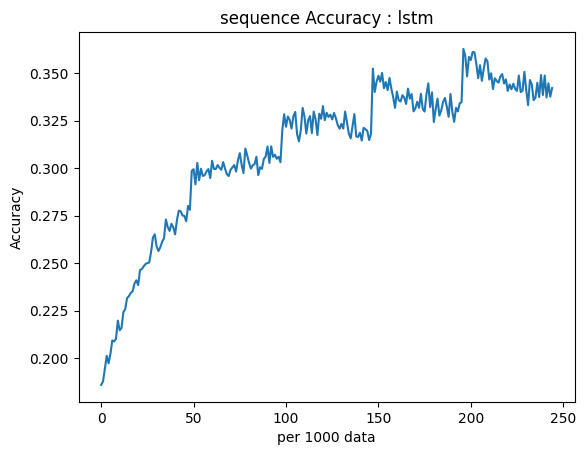

In [27]:
plt.plot(seqAccLSTM)
plt.ylabel('Accuracy')
plt.xlabel('per 1000 data')
plt.title("sequence Accuracy : lstm")


Text(0.5, 1.0, 'sequence loss : lstm')

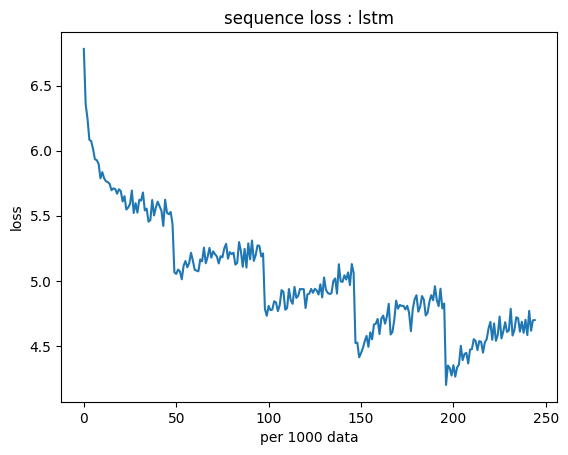

In [28]:
plt.plot(seqLossLSTM)
plt.ylabel('loss')
plt.xlabel('per 1000 data')
plt.title("sequence loss : lstm")


In [30]:
# evaluate model
test_sentence = "به نام خداوند جان و خرد"
pred = evaluate(encoderLstm, decoderLstm, test_sentence, max_length, poemLang)
print("Input : ", test_sentence)
print("Output : ", ' '.join(pred))

Input :  به نام خداوند جان و خرد
Output :  بدیبای برگاه


In [18]:
torch.save(encoderLstm.state_dict(),"encoderLstm.pt")
torch.save(decoderLstm.state_dict(),"decoderLstm.pt")

# Part 2 : Sequence to Sequence with GRU

In [19]:
class GRUEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, bidirectional=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device=device)

In [20]:
class GRUDecoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(GRUDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, bidirectional=True)
        self.out = nn.Linear(2*hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = nn.functional.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
hidden_size = 256
max_length = 15
lr = 0.001
epochs = 5

loss_fn = nn.CrossEntropyLoss()
encoderGru = GRUEncoder(poemLang.n_words, hidden_size).to(device)
decoderGru = GRUDecoder(hidden_size, poemLang.n_words).to(device)
encoderOpt = torch.optim.Adam(encoderGru.parameters(), lr=lr)
decoderOpt = torch.optim.Adam(decoderGru.parameters(), lr=lr)

In [22]:
epochLossGRU, epochAccGRU, seqLossGRU, seqAccGRU = train (training_pairs,encoderGru, decoderGru, loss_fn,\
                                                                     encoderOpt, decoderOpt , epochs, max_length )

Epoch = 1


  2%|▏         | 1016/49608 [00:09<07:48, 103.72it/s]

Average Loss = 6.87690669723693 Average Acc = 0.18081468253968166


  4%|▍         | 2015/49608 [00:19<07:34, 104.74it/s]

Average Loss = 6.4477216543914695 Average Acc = 0.18617305194805078


  6%|▌         | 3021/49608 [00:28<07:20, 105.68it/s]

Average Loss = 6.260929823555887 Average Acc = 0.19539375901875794


  8%|▊         | 4013/49608 [00:38<07:30, 101.14it/s]

Average Loss = 6.140222006660588 Average Acc = 0.19935999278499159


 10%|█         | 5011/49608 [00:47<07:13, 102.79it/s]

Average Loss = 6.076873807887016 Average Acc = 0.2068176046176035


 12%|█▏        | 6013/49608 [00:57<06:55, 104.92it/s]

Average Loss = 6.019256059904019 Average Acc = 0.21499516594516513


 14%|█▍        | 7019/49608 [01:07<06:43, 105.44it/s]

Average Loss = 5.9390121040343535 Average Acc = 0.21390483405483318


 16%|█▌        | 8016/49608 [01:16<06:38, 104.34it/s]

Average Loss = 5.86145440919575 Average Acc = 0.2168455627705614


 18%|█▊        | 9021/49608 [01:26<06:27, 104.75it/s]

Average Loss = 5.81828193333717 Average Acc = 0.22508899711399577


 20%|██        | 10013/49608 [01:35<06:23, 103.36it/s]

Average Loss = 5.769594295145009 Average Acc = 0.22324859307359207


 22%|██▏       | 11019/49608 [01:45<06:07, 104.90it/s]

Average Loss = 5.792509168506809 Average Acc = 0.226742460317459


 24%|██▍       | 12013/49608 [01:54<05:53, 106.31it/s]

Average Loss = 5.690519456742577 Average Acc = 0.23614917027416893


 26%|██▌       | 13020/49608 [02:04<05:53, 103.44it/s]

Average Loss = 5.728691965841731 Average Acc = 0.2318992424242413


 28%|██▊       | 14013/49608 [02:14<05:39, 104.94it/s]

Average Loss = 5.7784378794267575 Average Acc = 0.2301501443001431


 30%|███       | 15019/49608 [02:23<05:29, 104.92it/s]

Average Loss = 5.666331702533567 Average Acc = 0.2429573232323222


 32%|███▏      | 16012/49608 [02:33<05:14, 106.72it/s]

Average Loss = 5.645488363890209 Average Acc = 0.24141010101009946


 34%|███▍      | 17019/49608 [02:42<05:05, 106.56it/s]

Average Loss = 5.664709119084528 Average Acc = 0.2429984126984114


 36%|███▋      | 18013/49608 [02:52<05:06, 103.00it/s]

Average Loss = 5.521814895366385 Average Acc = 0.24740396825396707


 38%|███▊      | 19012/49608 [03:01<04:51, 105.12it/s]

Average Loss = 5.592779579598363 Average Acc = 0.2380097402597389


 40%|████      | 20013/49608 [03:11<04:43, 104.25it/s]

Average Loss = 5.654864116868587 Average Acc = 0.24015479797979658


 42%|████▏     | 21018/49608 [03:20<04:30, 105.80it/s]

Average Loss = 5.608526476800465 Average Acc = 0.2516257215007202


 44%|████▍     | 22013/49608 [03:30<04:23, 104.90it/s]

Average Loss = 5.545960306577006 Average Acc = 0.25445851370851236


 46%|████▋     | 23016/49608 [03:39<04:16, 103.55it/s]

Average Loss = 5.559439593648426 Average Acc = 0.2546575757575746


 48%|████▊     | 24016/49608 [03:49<04:02, 105.60it/s]

Average Loss = 5.495330601856994 Average Acc = 0.25491771284271186


 50%|█████     | 25014/49608 [03:58<03:51, 106.34it/s]

Average Loss = 5.456562424143118 Average Acc = 0.2597472582972569


 52%|█████▏    | 26011/49608 [04:08<03:51, 102.02it/s]

Average Loss = 5.514494523460902 Average Acc = 0.2591450216450203


 54%|█████▍    | 27015/49608 [04:18<03:33, 105.61it/s]

Average Loss = 5.428397547587794 Average Acc = 0.2645105699855686


 56%|█████▋    | 28011/49608 [04:27<03:28, 103.76it/s]

Average Loss = 5.4650984136933705 Average Acc = 0.25983556998556856


 58%|█████▊    | 29015/49608 [04:37<03:14, 105.90it/s]

Average Loss = 5.525583875488024 Average Acc = 0.26470454545454425


 61%|██████    | 30020/49608 [04:46<03:07, 104.73it/s]

Average Loss = 5.40730639796175 Average Acc = 0.2649033189033178


 63%|██████▎   | 31013/49608 [04:56<02:49, 109.44it/s]

Average Loss = 5.496103031160033 Average Acc = 0.2618533549783538


 65%|██████▍   | 32021/49608 [05:05<02:50, 103.22it/s]

Average Loss = 5.508693619321779 Average Acc = 0.2566227633477624


 67%|██████▋   | 33013/49608 [05:15<02:41, 102.84it/s]

Average Loss = 5.4245711636627965 Average Acc = 0.26163344155844054


 69%|██████▊   | 34018/49608 [05:25<02:27, 105.77it/s]

Average Loss = 5.520478985258895 Average Acc = 0.26865238095238014


 71%|███████   | 35014/49608 [05:34<02:17, 105.96it/s]

Average Loss = 5.459496713781152 Average Acc = 0.26737716450216353


 73%|███████▎  | 36022/49608 [05:44<02:10, 103.99it/s]

Average Loss = 5.420157987595804 Average Acc = 0.2683705988455976


 75%|███████▍  | 37019/49608 [05:53<02:01, 103.97it/s]

Average Loss = 5.470479976848641 Average Acc = 0.2691738095238086


 77%|███████▋  | 38021/49608 [06:03<01:50, 104.57it/s]

Average Loss = 5.4391559561557035 Average Acc = 0.27297637085136983


 79%|███████▊  | 39015/49608 [06:12<01:40, 105.26it/s]

Average Loss = 5.3511030857871305 Average Acc = 0.2706303391053383


 81%|████████  | 40011/49608 [06:22<01:31, 104.82it/s]

Average Loss = 5.412080151017569 Average Acc = 0.27002164502164394


 83%|████████▎ | 41015/49608 [06:32<01:20, 107.25it/s]

Average Loss = 5.408188583956542 Average Acc = 0.2730750360750348


 85%|████████▍ | 42017/49608 [06:41<01:12, 105.31it/s]

Average Loss = 5.471851550035775 Average Acc = 0.2722014069264061


 87%|████████▋ | 43022/49608 [06:51<01:02, 105.27it/s]

Average Loss = 5.500510163814442 Average Acc = 0.27132662337662206


 89%|████████▊ | 44017/49608 [07:00<00:53, 103.95it/s]

Average Loss = 5.43100838576726 Average Acc = 0.2793793650793641


 91%|█████████ | 45020/49608 [07:10<00:44, 104.08it/s]

Average Loss = 5.345136151573462 Average Acc = 0.2884417027417019


 93%|█████████▎| 46012/49608 [07:19<00:34, 104.14it/s]

Average Loss = 5.327725875397257 Average Acc = 0.2812455627705621


 95%|█████████▍| 47015/49608 [07:29<00:24, 105.80it/s]

Average Loss = 5.370738891507707 Average Acc = 0.2801289682539675


 97%|█████████▋| 48019/49608 [07:39<00:14, 106.76it/s]

Average Loss = 5.353122777377296 Average Acc = 0.27798618326118274


 99%|█████████▉| 49011/49608 [07:48<00:05, 104.71it/s]

Average Loss = 5.404921047478825 Average Acc = 0.28182359307359245


100%|██████████| 49608/49608 [07:54<00:00, 104.60it/s]


Epoch = 2


  2%|▏         | 1018/49608 [00:09<07:46, 104.24it/s]

Average Loss = 4.84506608269972 Average Acc = 0.30956706349206253


  4%|▍         | 2011/49608 [00:19<07:39, 103.59it/s]

Average Loss = 4.818566259752386 Average Acc = 0.3121321428571419


  6%|▌         | 3013/49608 [00:28<07:29, 103.66it/s]

Average Loss = 4.775388271255417 Average Acc = 0.3058572871572869


  8%|▊         | 4020/49608 [00:38<07:25, 102.22it/s]

Average Loss = 4.731528653085184 Average Acc = 0.3153608225108214


 10%|█         | 5013/49608 [00:48<07:05, 104.93it/s]

Average Loss = 4.843739425648511 Average Acc = 0.3105633116883111


 12%|█▏        | 6018/49608 [00:57<07:04, 102.69it/s]

Average Loss = 4.960961233384834 Average Acc = 0.30046230158730014


 14%|█▍        | 7012/49608 [01:07<06:47, 104.53it/s]

Average Loss = 4.839622910271745 Average Acc = 0.31177301587301526


 16%|█▌        | 8021/49608 [01:17<06:35, 105.26it/s]

Average Loss = 4.854374194333456 Average Acc = 0.30350400432900343


 18%|█▊        | 9016/49608 [01:26<06:24, 105.44it/s]

Average Loss = 5.037855261312285 Average Acc = 0.3008765512265507


 20%|██        | 10018/49608 [01:36<06:22, 103.62it/s]

Average Loss = 4.904765589400465 Average Acc = 0.3023997474747475


 22%|██▏       | 11012/49608 [01:45<06:05, 105.58it/s]

Average Loss = 5.012304347416231 Average Acc = 0.2979136724386718


 24%|██▍       | 12017/49608 [01:55<05:57, 105.30it/s]

Average Loss = 4.867894950986555 Average Acc = 0.31029704184704077


 26%|██▌       | 13021/49608 [02:05<05:55, 102.90it/s]

Average Loss = 4.9035853147479145 Average Acc = 0.3109300144300136


 28%|██▊       | 14012/49608 [02:14<05:39, 104.86it/s]

Average Loss = 4.971861116721241 Average Acc = 0.3059095959595953


 30%|███       | 15017/49608 [02:24<05:33, 103.76it/s]

Average Loss = 5.033410362361689 Average Acc = 0.3090551948051947


 32%|███▏      | 16013/49608 [02:33<05:16, 106.07it/s]

Average Loss = 5.024820881799291 Average Acc = 0.3007948412698407


 34%|███▍      | 17014/49608 [02:43<05:13, 104.01it/s]

Average Loss = 4.902565219545399 Average Acc = 0.3103322510822504


 36%|███▋      | 18018/49608 [02:52<05:04, 103.91it/s]

Average Loss = 4.980832855696453 Average Acc = 0.3020378427128423


 38%|███▊      | 19022/49608 [03:02<04:50, 105.41it/s]

Average Loss = 5.093898805923232 Average Acc = 0.2997567460317455


 40%|████      | 20016/49608 [03:12<04:38, 106.28it/s]

Average Loss = 5.022435095170394 Average Acc = 0.2992604256854253


 42%|████▏     | 21012/49608 [03:21<04:30, 105.82it/s]

Average Loss = 5.140704399444292 Average Acc = 0.30191814574314507


 44%|████▍     | 22011/49608 [03:30<04:22, 105.21it/s]

Average Loss = 5.052009392797072 Average Acc = 0.31144411976911907


 46%|████▋     | 23014/49608 [03:40<04:16, 103.62it/s]

Average Loss = 4.922809310740621 Average Acc = 0.3172590548340545


 48%|████▊     | 24016/49608 [03:50<04:07, 103.50it/s]

Average Loss = 5.0180678794832945 Average Acc = 0.2992751803751797


 50%|█████     | 25020/49608 [03:59<03:52, 105.81it/s]

Average Loss = 5.044225555513645 Average Acc = 0.30517792207792144


 52%|█████▏    | 26012/49608 [04:09<03:47, 103.58it/s]

Average Loss = 5.017018251035702 Average Acc = 0.3069591269841264


 54%|█████▍    | 27015/49608 [04:19<03:35, 104.88it/s]

Average Loss = 5.0924404587414465 Average Acc = 0.3058084776334768


 56%|█████▋    | 28021/49608 [04:28<03:26, 104.45it/s]

Average Loss = 4.966416133342603 Average Acc = 0.31056562049061964


 58%|█████▊    | 29015/49608 [04:38<03:14, 106.08it/s]

Average Loss = 5.0547622000910994 Average Acc = 0.30731511544011514


 61%|██████    | 30019/49608 [04:47<03:09, 103.51it/s]

Average Loss = 5.0915740846483875 Average Acc = 0.30561616161616095


 63%|██████▎   | 31012/49608 [04:57<02:55, 105.91it/s]

Average Loss = 5.085321941991419 Average Acc = 0.3011308080808071


 65%|██████▍   | 32017/49608 [05:06<02:48, 104.57it/s]

Average Loss = 5.098283693249157 Average Acc = 0.3043135642135634


 67%|██████▋   | 33022/49608 [05:16<02:36, 105.74it/s]

Average Loss = 5.043120995304626 Average Acc = 0.30896601731601675


 69%|██████▊   | 34016/49608 [05:25<02:27, 105.40it/s]

Average Loss = 5.00740977873773 Average Acc = 0.31436645021644954


 71%|███████   | 35012/49608 [05:35<02:19, 104.83it/s]

Average Loss = 5.030190713281106 Average Acc = 0.31696865079364955


 73%|███████▎  | 36016/49608 [05:44<02:09, 104.73it/s]

Average Loss = 5.1102671462976925 Average Acc = 0.31375941558441534


 75%|███████▍  | 37021/49608 [05:54<02:00, 104.88it/s]

Average Loss = 5.063880679005116 Average Acc = 0.3066582611832603


 77%|███████▋  | 38016/49608 [06:04<01:50, 104.81it/s]

Average Loss = 5.064671143888362 Average Acc = 0.31403466810966735


 79%|███████▊  | 39018/49608 [06:13<01:41, 104.04it/s]

Average Loss = 5.0499001432150665 Average Acc = 0.3059469336219335


 81%|████████  | 40019/49608 [06:23<01:32, 103.38it/s]

Average Loss = 5.153136351504781 Average Acc = 0.30556825396825293


 83%|████████▎ | 41014/49608 [06:32<01:20, 106.53it/s]

Average Loss = 5.0177742436645385 Average Acc = 0.30651183261183146


 85%|████████▍ | 42021/49608 [06:42<01:12, 105.24it/s]

Average Loss = 5.180291223701424 Average Acc = 0.31276277056276974


 87%|████████▋ | 43019/49608 [06:51<01:02, 104.85it/s]

Average Loss = 4.986107151724519 Average Acc = 0.31604689754689685


 89%|████████▊ | 44022/49608 [07:01<00:53, 104.06it/s]

Average Loss = 5.078600564673526 Average Acc = 0.310684523809523


 91%|█████████ | 45014/49608 [07:11<00:45, 101.63it/s]

Average Loss = 5.07370625156551 Average Acc = 0.30447680375180297


 93%|█████████▎| 46018/49608 [07:20<00:34, 104.82it/s]

Average Loss = 5.037083690021881 Average Acc = 0.3148294733044731


 95%|█████████▍| 47014/49608 [07:30<00:25, 103.48it/s]

Average Loss = 5.055341308028192 Average Acc = 0.31606345598845564


 97%|█████████▋| 48021/49608 [07:39<00:15, 104.50it/s]

Average Loss = 5.136733277015462 Average Acc = 0.3125420634920627


 99%|█████████▉| 49018/49608 [07:49<00:05, 106.15it/s]

Average Loss = 5.19261714547589 Average Acc = 0.30006298701298656


100%|██████████| 49608/49608 [07:54<00:00, 104.45it/s]


Epoch = 3


  2%|▏         | 1017/49608 [00:09<07:45, 104.49it/s]

Average Loss = 4.345067892313695 Average Acc = 0.35123823953823863


  4%|▍         | 2022/49608 [00:19<07:39, 103.65it/s]

Average Loss = 4.340056458543904 Average Acc = 0.34784188311688247


  6%|▌         | 3014/49608 [00:28<07:21, 105.42it/s]

Average Loss = 4.3132080787262685 Average Acc = 0.3411636363636353


  8%|▊         | 4019/49608 [00:38<07:20, 103.47it/s]

Average Loss = 4.339092393883722 Average Acc = 0.3486090548340543


 10%|█         | 5022/49608 [00:48<06:52, 108.16it/s]

Average Loss = 4.39664496601956 Average Acc = 0.34556212121212077


 12%|█▏        | 6019/49608 [00:57<06:53, 105.46it/s]

Average Loss = 4.374472603803594 Average Acc = 0.3416602453102449


 14%|█▍        | 7012/49608 [01:07<06:44, 105.28it/s]

Average Loss = 4.409673637629566 Average Acc = 0.3517832611832612


 16%|█▌        | 8021/49608 [01:16<06:32, 105.98it/s]

Average Loss = 4.461405039908499 Average Acc = 0.34699538239538164


 18%|█▊        | 9014/49608 [01:26<06:30, 103.88it/s]

Average Loss = 4.4172575600382205 Average Acc = 0.3406689033189028


 20%|██        | 10020/49608 [01:35<06:21, 103.69it/s]

Average Loss = 4.440164787673526 Average Acc = 0.343790656565656


 22%|██▏       | 11016/49608 [01:45<06:14, 102.99it/s]

Average Loss = 4.4904567121744545 Average Acc = 0.3384462842712841


 24%|██▍       | 12012/49608 [01:54<05:58, 104.79it/s]

Average Loss = 4.507106162058978 Average Acc = 0.34030858585858537


 26%|██▌       | 13017/49608 [02:04<05:53, 103.43it/s]

Average Loss = 4.5641309266281995 Average Acc = 0.33458214285714183


 28%|██▊       | 14012/49608 [02:13<05:42, 104.04it/s]

Average Loss = 4.6604031249701 Average Acc = 0.3389428210678204


 30%|███       | 15017/49608 [02:23<05:27, 105.47it/s]

Average Loss = 4.533909457411854 Average Acc = 0.33841479076479053


 32%|███▏      | 16011/49608 [02:33<05:21, 104.49it/s]

Average Loss = 4.5599676807142115 Average Acc = 0.3362102813852806


 34%|███▍      | 17018/49608 [02:42<05:08, 105.66it/s]

Average Loss = 4.637735716226881 Average Acc = 0.3287935064935057


 36%|███▋      | 18013/49608 [02:52<05:03, 104.16it/s]

Average Loss = 4.57281384454097 Average Acc = 0.33068906926406916


 38%|███▊      | 19016/49608 [03:01<04:56, 103.27it/s]

Average Loss = 4.566463584125694 Average Acc = 0.3347777777777773


 40%|████      | 20021/49608 [03:11<04:46, 103.38it/s]

Average Loss = 4.5534078543049965 Average Acc = 0.33188650793650704


 42%|████▏     | 21015/49608 [03:20<04:33, 104.49it/s]

Average Loss = 4.553680646312358 Average Acc = 0.3391326479076477


 44%|████▍     | 22018/49608 [03:30<04:29, 102.29it/s]

Average Loss = 4.6547057767084645 Average Acc = 0.3355892857142849


 46%|████▋     | 23022/49608 [03:40<04:10, 106.02it/s]

Average Loss = 4.684959703706833 Average Acc = 0.3337397546897538


 48%|████▊     | 24015/49608 [03:49<04:06, 103.85it/s]

Average Loss = 4.636059911001466 Average Acc = 0.3375790043290038


 50%|█████     | 25021/49608 [03:59<03:54, 104.68it/s]

Average Loss = 4.743257367852425 Average Acc = 0.3266974025974022


 52%|█████▏    | 26014/49608 [04:08<03:46, 104.07it/s]

Average Loss = 4.86021071544427 Average Acc = 0.33105266955266904


 54%|█████▍    | 27017/49608 [04:18<03:35, 105.01it/s]

Average Loss = 4.712926707481827 Average Acc = 0.3337160533910528


 56%|█████▋    | 28012/49608 [04:27<03:27, 104.09it/s]

Average Loss = 4.789399537032756 Average Acc = 0.3265230158730151


 58%|█████▊    | 29016/49608 [04:37<03:15, 105.33it/s]

Average Loss = 4.710428219326959 Average Acc = 0.33022272727272667


 60%|██████    | 30011/49608 [04:47<03:07, 104.56it/s]

Average Loss = 4.802804871598875 Average Acc = 0.322484126984126


 63%|██████▎   | 31017/49608 [04:56<02:58, 103.89it/s]

Average Loss = 4.754811496871927 Average Acc = 0.33088196248196133


 65%|██████▍   | 32016/49608 [05:06<02:48, 104.24it/s]

Average Loss = 4.782377265047919 Average Acc = 0.3257839105339102


 67%|██████▋   | 33021/49608 [05:15<02:39, 104.05it/s]

Average Loss = 4.80236892921065 Average Acc = 0.3316811688311683


 69%|██████▊   | 34017/49608 [05:25<02:29, 104.39it/s]

Average Loss = 4.8171803436991265 Average Acc = 0.330819155844155


 71%|███████   | 35015/49608 [05:34<02:17, 106.02it/s]

Average Loss = 4.844465819688471 Average Acc = 0.32704866522366466


 73%|███████▎  | 36020/49608 [05:44<02:08, 105.43it/s]

Average Loss = 4.797686529282538 Average Acc = 0.3286246031746031


 75%|███████▍  | 37013/49608 [05:53<02:00, 104.49it/s]

Average Loss = 4.812025193458512 Average Acc = 0.3315948412698406


 77%|███████▋  | 38016/49608 [06:03<01:50, 104.48it/s]

Average Loss = 4.789061856438932 Average Acc = 0.32971406926406854


 79%|███████▊  | 39022/49608 [06:13<01:39, 106.02it/s]

Average Loss = 4.841150594548059 Average Acc = 0.3230317821067814


 81%|████████  | 40015/49608 [06:22<01:31, 104.63it/s]

Average Loss = 4.748915182203332 Average Acc = 0.3289834415584407


 83%|████████▎ | 41011/49608 [06:32<01:22, 104.72it/s]

Average Loss = 4.765489583583856 Average Acc = 0.3232773809523806


 85%|████████▍ | 42018/49608 [06:41<01:12, 104.19it/s]

Average Loss = 4.724490883341124 Average Acc = 0.3391036796536787


 87%|████████▋ | 43021/49608 [06:51<01:03, 103.83it/s]

Average Loss = 4.745692306663594 Average Acc = 0.3264076839826837


 89%|████████▊ | 44018/49608 [07:00<00:53, 104.93it/s]

Average Loss = 4.877425329740223 Average Acc = 0.32037287157287114


 91%|█████████ | 45012/49608 [07:10<00:43, 105.77it/s]

Average Loss = 4.6966600513068775 Average Acc = 0.33335375180375104


 93%|█████████▎| 46018/49608 [07:19<00:34, 104.75it/s]

Average Loss = 4.8016205380811705 Average Acc = 0.33080284992784953


 95%|█████████▍| 47011/49608 [07:29<00:25, 103.12it/s]

Average Loss = 4.68334590127429 Average Acc = 0.3331731240981235


 97%|█████████▋| 48015/49608 [07:38<00:14, 107.84it/s]

Average Loss = 4.831524151439895 Average Acc = 0.32930342712842686


 99%|█████████▉| 49020/49608 [07:48<00:05, 105.49it/s]

Average Loss = 4.828850990180572 Average Acc = 0.33122326839826766


100%|██████████| 49608/49608 [07:54<00:00, 104.64it/s]


Epoch = 4


  2%|▏         | 1016/49608 [00:09<07:42, 105.11it/s]

Average Loss = 3.904747685246621 Average Acc = 0.3746880952380953


  4%|▍         | 2012/49608 [00:19<07:30, 105.59it/s]

Average Loss = 3.8840104424631923 Average Acc = 0.3792906565656559


  6%|▌         | 3017/49608 [00:28<07:27, 104.10it/s]

Average Loss = 3.9101587840136975 Average Acc = 0.3687365079365074


  8%|▊         | 4014/49608 [00:38<07:15, 104.75it/s]

Average Loss = 3.9372154283703535 Average Acc = 0.37302875180375106


 10%|█         | 5017/49608 [00:48<07:18, 101.73it/s]

Average Loss = 4.0193853959034165 Average Acc = 0.3715018398268391


 12%|█▏        | 6022/49608 [00:57<06:52, 105.62it/s]

Average Loss = 3.9568724244717415 Average Acc = 0.37163203463203337


 14%|█▍        | 7017/49608 [01:07<06:44, 105.21it/s]

Average Loss = 4.0280070353388915 Average Acc = 0.37584487734487704


 16%|█▌        | 8022/49608 [01:16<06:40, 103.80it/s]

Average Loss = 4.11639861492025 Average Acc = 0.3597991702741693


 18%|█▊        | 9013/49608 [01:26<06:26, 104.91it/s]

Average Loss = 4.113109057721362 Average Acc = 0.3537023809523808


 20%|██        | 10016/49608 [01:36<06:10, 106.90it/s]

Average Loss = 4.09536882157162 Average Acc = 0.3585851010101005


 22%|██▏       | 11015/49608 [01:45<06:00, 107.03it/s]

Average Loss = 4.105541407654673 Average Acc = 0.3678131673881665


 24%|██▍       | 12022/49608 [01:55<05:55, 105.78it/s]

Average Loss = 4.18769638676742 Average Acc = 0.3548509379509371


 26%|██▌       | 13013/49608 [02:04<05:51, 103.98it/s]

Average Loss = 4.210210691218084 Average Acc = 0.35563823953823936


 28%|██▊       | 14017/49608 [02:14<05:39, 104.82it/s]

Average Loss = 4.3000615247799745 Average Acc = 0.35142499999999977


 30%|███       | 15020/49608 [02:24<05:25, 106.29it/s]

Average Loss = 4.325205189329582 Average Acc = 0.3479891414141406


 32%|███▏      | 16017/49608 [02:33<05:26, 102.84it/s]

Average Loss = 4.247486047738041 Average Acc = 0.3435434704184698


 34%|███▍      | 17021/49608 [02:43<05:10, 104.95it/s]

Average Loss = 4.2849358602516885 Average Acc = 0.3495989898989896


 36%|███▋      | 18015/49608 [02:52<05:02, 104.35it/s]

Average Loss = 4.237520576609474 Average Acc = 0.35080750360750307


 38%|███▊      | 19018/49608 [03:02<04:47, 106.33it/s]

Average Loss = 4.337258579190533 Average Acc = 0.3439795454545452


 40%|████      | 20020/49608 [03:12<04:43, 104.47it/s]

Average Loss = 4.274526319912537 Average Acc = 0.35034585137085084


 42%|████▏     | 21013/49608 [03:21<04:33, 104.61it/s]

Average Loss = 4.41173924788348 Average Acc = 0.341791738816738


 44%|████▍     | 22017/49608 [03:31<04:22, 105.09it/s]

Average Loss = 4.307237267242227 Average Acc = 0.3581401515151506


 46%|████▋     | 23013/49608 [03:40<04:13, 104.72it/s]

Average Loss = 4.316266565559712 Average Acc = 0.36208069985569896


 48%|████▊     | 24016/49608 [03:50<04:07, 103.20it/s]

Average Loss = 4.387790151733619 Average Acc = 0.3436963203463199


 50%|█████     | 25022/49608 [03:59<03:50, 106.62it/s]

Average Loss = 4.400138815445269 Average Acc = 0.35049260461760373


 52%|█████▏    | 26021/49608 [04:09<03:42, 106.03it/s]

Average Loss = 4.388717389443631 Average Acc = 0.34906244588744545


 54%|█████▍    | 27013/49608 [04:18<03:37, 103.84it/s]

Average Loss = 4.299141641187082 Average Acc = 0.3527884920634918


 56%|█████▋    | 28018/49608 [04:28<03:25, 105.24it/s]

Average Loss = 4.423521984609833 Average Acc = 0.344666233766233


 58%|█████▊    | 29013/49608 [04:37<03:19, 103.08it/s]

Average Loss = 4.401970413121725 Average Acc = 0.34630634920634884


 61%|██████    | 30018/49608 [04:47<03:06, 105.15it/s]

Average Loss = 4.423067566971207 Average Acc = 0.34867904040403935


 63%|██████▎   | 31013/49608 [04:56<02:55, 105.89it/s]

Average Loss = 4.474173425747155 Average Acc = 0.344513672438672


 65%|██████▍   | 32018/49608 [05:06<02:51, 102.35it/s]

Average Loss = 4.367485559292396 Average Acc = 0.35017186147186125


 67%|██████▋   | 33012/49608 [05:16<02:39, 103.96it/s]

Average Loss = 4.376454185895003 Average Acc = 0.3468746392496388


 69%|██████▊   | 34016/49608 [05:25<02:28, 104.91it/s]

Average Loss = 4.486331236282575 Average Acc = 0.34450115440115375


 71%|███████   | 35021/49608 [05:35<02:22, 102.16it/s]

Average Loss = 4.503161829696246 Average Acc = 0.3400974747474738


 73%|███████▎  | 36012/49608 [05:44<02:08, 105.57it/s]

Average Loss = 4.441319007751864 Average Acc = 0.3476738095238091


 75%|███████▍  | 37017/49608 [05:54<02:00, 104.41it/s]

Average Loss = 4.414806819958785 Average Acc = 0.34156360028860006


 77%|███████▋  | 38021/49608 [06:03<01:50, 105.29it/s]

Average Loss = 4.442482902946889 Average Acc = 0.34542788600288576


 79%|███████▊  | 39014/49608 [06:13<01:40, 105.88it/s]

Average Loss = 4.455883958918265 Average Acc = 0.3426382756132748


 81%|████████  | 40015/49608 [06:23<01:32, 103.76it/s]

Average Loss = 4.572408802835557 Average Acc = 0.33059422799422794


 83%|████████▎ | 41018/49608 [06:32<01:21, 105.00it/s]

Average Loss = 4.4825605725624795 Average Acc = 0.3451038600288601


 85%|████████▍ | 42015/49608 [06:42<01:12, 104.89it/s]

Average Loss = 4.558655823360166 Average Acc = 0.33798650793650714


 87%|████████▋ | 43020/49608 [06:51<01:02, 105.55it/s]

Average Loss = 4.678020289182953 Average Acc = 0.332257575757575


 89%|████████▊ | 44022/49608 [07:01<00:54, 103.13it/s]

Average Loss = 4.463397459000082 Average Acc = 0.3385567460317451


 91%|█████████ | 45021/49608 [07:10<00:43, 105.99it/s]

Average Loss = 4.579326829368355 Average Acc = 0.3417333333333326


 93%|█████████▎| 46013/49608 [07:20<00:34, 103.66it/s]

Average Loss = 4.512581958934681 Average Acc = 0.343181204906204


 95%|█████████▍| 47016/49608 [07:30<00:24, 104.84it/s]

Average Loss = 4.55875666936452 Average Acc = 0.3370303030303021


 97%|█████████▋| 48022/49608 [07:39<00:15, 104.30it/s]

Average Loss = 4.67832410696668 Average Acc = 0.33364531024530986


 99%|█████████▉| 49017/49608 [07:49<00:05, 104.03it/s]

Average Loss = 4.599301220125312 Average Acc = 0.33662362914862803


100%|██████████| 49608/49608 [07:54<00:00, 104.47it/s]


Epoch = 5


  2%|▏         | 1016/49608 [00:09<07:45, 104.35it/s]

Average Loss = 3.6201473633217387 Average Acc = 0.39400753968253877


  4%|▍         | 2019/49608 [00:19<07:32, 105.24it/s]

Average Loss = 3.539615849876712 Average Acc = 0.39526930014429984


  6%|▌         | 3013/49608 [00:28<07:17, 106.51it/s]

Average Loss = 3.6178860045010746 Average Acc = 0.3924372655122649


  8%|▊         | 4017/49608 [00:38<07:13, 105.09it/s]

Average Loss = 3.617661969472271 Average Acc = 0.39559033189033105


 10%|█         | 5021/49608 [00:48<07:04, 105.15it/s]

Average Loss = 3.5749951718091957 Average Acc = 0.38755277777777714


 12%|█▏        | 6017/49608 [00:57<07:02, 103.18it/s]

Average Loss = 3.7512317082319795 Average Acc = 0.3829287157287149


 14%|█▍        | 7013/49608 [01:07<06:51, 103.55it/s]

Average Loss = 3.7685192094600186 Average Acc = 0.37910826118326035


 16%|█▌        | 8011/49608 [01:16<06:45, 102.66it/s]

Average Loss = 3.836998817667203 Average Acc = 0.37608354978354924


 18%|█▊        | 9013/49608 [01:26<06:24, 105.45it/s]

Average Loss = 3.7524892458449544 Average Acc = 0.38226114718614657


 20%|██        | 10014/49608 [01:35<06:16, 105.27it/s]

Average Loss = 3.750007153876087 Average Acc = 0.37710147907647845


 22%|██▏       | 11016/49608 [01:45<06:04, 105.82it/s]

Average Loss = 3.9026410058823298 Average Acc = 0.36728340548340493


 24%|██▍       | 12017/49608 [01:55<05:55, 105.84it/s]

Average Loss = 3.8985426719037304 Average Acc = 0.37760952380952323


 26%|██▌       | 13021/49608 [02:04<05:50, 104.52it/s]

Average Loss = 3.942259288144127 Average Acc = 0.38016165223665177


 28%|██▊       | 14017/49608 [02:14<05:35, 105.95it/s]

Average Loss = 3.89610952751017 Average Acc = 0.3747383477633474


 30%|███       | 15014/49608 [02:23<05:31, 104.39it/s]

Average Loss = 3.9395251352524245 Average Acc = 0.3646986652236653


 32%|███▏      | 16020/49608 [02:33<05:17, 105.73it/s]

Average Loss = 3.930282500313908 Average Acc = 0.37380782828282827


 34%|███▍      | 17013/49608 [02:42<05:10, 104.96it/s]

Average Loss = 4.004441629591579 Average Acc = 0.36343755411255285


 36%|███▋      | 18019/49608 [02:52<05:02, 104.35it/s]

Average Loss = 4.111327042080865 Average Acc = 0.3592912698412693


 38%|███▊      | 19012/49608 [03:02<04:53, 104.40it/s]

Average Loss = 4.043283083945281 Average Acc = 0.35877590187590136


 40%|████      | 20018/49608 [03:11<04:41, 105.20it/s]

Average Loss = 4.025682225062014 Average Acc = 0.368352669552669


 42%|████▏     | 21021/49608 [03:21<04:37, 103.05it/s]

Average Loss = 4.076475103796581 Average Acc = 0.3647455988455984


 44%|████▍     | 22012/49608 [03:30<04:23, 104.92it/s]

Average Loss = 4.096421316337362 Average Acc = 0.3611485569985566


 46%|████▋     | 23015/49608 [03:40<04:20, 102.02it/s]

Average Loss = 4.023035401807895 Average Acc = 0.3741202380952376


 48%|████▊     | 24017/49608 [03:49<04:03, 105.06it/s]

Average Loss = 4.120381562480579 Average Acc = 0.35845689033188954


 50%|█████     | 25021/49608 [03:59<03:54, 104.86it/s]

Average Loss = 4.210249507648226 Average Acc = 0.3557484126984124


 52%|█████▏    | 26014/49608 [04:09<03:46, 104.15it/s]

Average Loss = 4.0947761648784535 Average Acc = 0.36057597402597363


 54%|█████▍    | 27011/49608 [04:18<03:33, 105.64it/s]

Average Loss = 4.1593526200605515 Average Acc = 0.3608024531024525


 56%|█████▋    | 28018/49608 [04:28<03:26, 104.44it/s]

Average Loss = 4.197646262482803 Average Acc = 0.34980714285714254


 58%|█████▊    | 29013/49608 [04:37<03:22, 101.90it/s]

Average Loss = 4.163795525652091 Average Acc = 0.357026623376623


 61%|██████    | 30017/49608 [04:47<03:07, 104.52it/s]

Average Loss = 4.141174478930143 Average Acc = 0.36027117604617503


 63%|██████▎   | 31020/49608 [04:56<02:56, 105.18it/s]

Average Loss = 4.262448644516751 Average Acc = 0.35189751082251025


 65%|██████▍   | 32021/49608 [05:06<02:46, 105.58it/s]

Average Loss = 4.23283843109701 Average Acc = 0.3570739898989895


 67%|██████▋   | 33013/49608 [05:16<02:43, 101.78it/s]

Average Loss = 4.326968096808366 Average Acc = 0.3486180735930732


 69%|██████▊   | 34017/49608 [05:25<02:31, 102.70it/s]

Average Loss = 4.308697547351058 Average Acc = 0.3584218253968247


 71%|███████   | 35012/49608 [05:35<02:19, 104.76it/s]

Average Loss = 4.249816516828538 Average Acc = 0.35499523809523736


 73%|███████▎  | 36019/49608 [05:44<02:10, 103.75it/s]

Average Loss = 4.302977571266351 Average Acc = 0.3463257575757574


 75%|███████▍  | 37021/49608 [05:54<01:59, 104.95it/s]

Average Loss = 4.27933100756784 Average Acc = 0.34766565656565573


 77%|███████▋  | 38016/49608 [06:04<01:48, 106.53it/s]

Average Loss = 4.34666996835348 Average Acc = 0.3543395382395381


 79%|███████▊  | 39020/49608 [06:13<01:38, 107.34it/s]

Average Loss = 4.262405816161443 Average Acc = 0.35285559163059116


 81%|████████  | 40013/49608 [06:23<01:30, 105.47it/s]

Average Loss = 4.338638785681413 Average Acc = 0.3592775252525247


 83%|████████▎ | 41016/49608 [06:32<01:20, 106.74it/s]

Average Loss = 4.420625169161315 Average Acc = 0.3516644300144292


 85%|████████▍ | 42021/49608 [06:42<01:11, 105.88it/s]

Average Loss = 4.210071197388666 Average Acc = 0.35395952380952295


 87%|████████▋ | 43014/49608 [06:51<01:02, 105.56it/s]

Average Loss = 4.379610006164595 Average Acc = 0.3524042568542561


 89%|████████▊ | 44019/49608 [07:01<00:53, 105.21it/s]

Average Loss = 4.328459752453444 Average Acc = 0.3435745670995671


 91%|█████████ | 45012/49608 [07:10<00:44, 103.79it/s]

Average Loss = 4.500689378679367 Average Acc = 0.3462464285714279


 93%|█████████▎| 46015/49608 [07:20<00:34, 103.95it/s]

Average Loss = 4.374265337984523 Average Acc = 0.34878968253968207


 95%|█████████▍| 47013/49608 [07:30<00:24, 106.48it/s]

Average Loss = 4.358907737334191 Average Acc = 0.3430239538239534


 97%|█████████▋| 48018/49608 [07:39<00:15, 103.28it/s]

Average Loss = 4.3110286005642156 Average Acc = 0.35728596681096636


 99%|█████████▉| 49022/49608 [07:49<00:05, 106.73it/s]

Average Loss = 4.393136460655838 Average Acc = 0.3495305555555555


100%|██████████| 49608/49608 [07:54<00:00, 104.47it/s]


Text(0.5, 1.0, 'sequence Accuracy : gru')

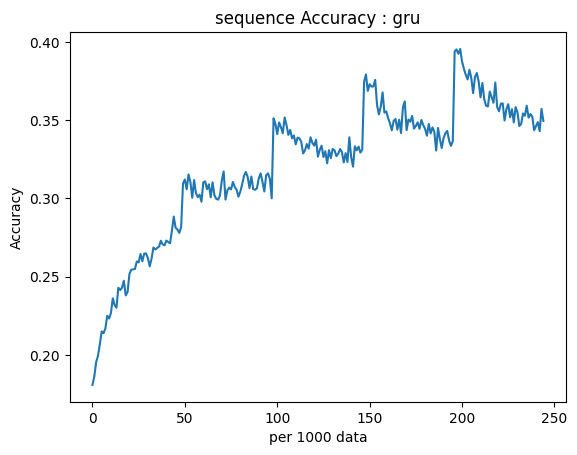

In [31]:
plt.plot(seqAccGRU)
plt.ylabel('Accuracy')
plt.xlabel('per 1000 data')
plt.title("sequence Accuracy : gru")

Text(0.5, 1.0, 'sequence loss : gru')

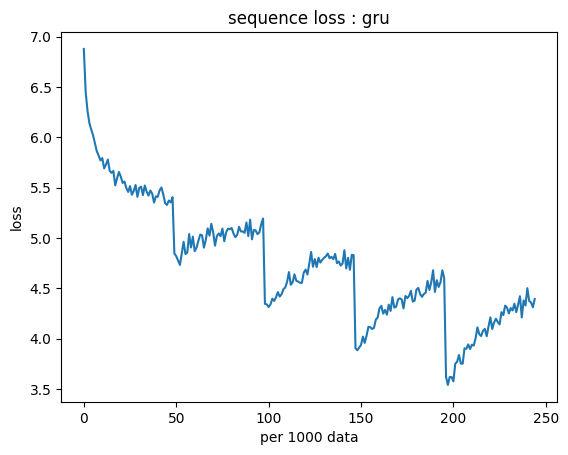

In [32]:
plt.plot(seqLossGRU)
plt.ylabel('loss')
plt.xlabel('per 1000 data')
plt.title("sequence loss : gru")

In [25]:
# evaluate model
test_sentence = "به نام خداوند جان و خرد"
pred = evaluate(encoderGru, decoderGru, test_sentence, max_length, poemLang)
print("Input : ", test_sentence)
print("Output : ", ' '.join(pred))

Input :  به نام خداوند جان و خرد
Output :  به جایی که بد زان جای بد شیر


In [26]:
torch.save(encoderGru.state_dict(),"encoderGru.pt")
torch.save(decoderGru.state_dict(),"decoderGru.pt")